In [1]:
%%bash
echo $CMSSW_BASE
echo $PWD

/afs/cern.ch/work/i/innocent/public/code/s7/CMSSW_9_3_0_pre2
/afs/cern.ch/user/i/innocent/POS2017/exercise2_TkHistos


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
from DataFormats.FWLite import Handle, Events

Welcome to JupyROOT 6.10/01


In [22]:
#LS50
events2016HL = Events("root://cms-xrd-global.cern.ch///store/data/Run2016H/JetHT/AOD/PromptReco-v2/000/283/408/00000/AE49FDAB-8398-E611-9B98-02163E014388.root")
#LS1000
events2016LL = Events("root://cms-xrd-global.cern.ch///store/data/Run2016H/JetHT/AOD/PromptReco-v2/000/283/408/00000/88FB6BA5-7B98-E611-B25E-FA163EE1CC08.root")

events2017B_HL = Events("root://cms-xrd-global.cern.ch///store/data/Run2017B/SingleMuon/AOD/PromptReco-v2/000/299/061/00000/5C4984B0-B86A-E711-837F-02163E01A792.root")
events2017B_LL = Events("root://cms-xrd-global.cern.ch///store/data/Run2017B/SingleMuon/AOD/PromptReco-v2/000/299/067/00000/B4146406-F66A-E711-B9C9-02163E014389.root")

tracks = Handle("std::vector<reco::Track>")
label = "generalTracks"
quality = "highPurity"

In [23]:
def nt(events) :
    nt = []
    for i in range(0,1000) : # events.size()):
      a= events.to(i)
      if (i%500==0) : print "Event", i 
      a=events.getByLabel(label, tracks)
      nt.append(tracks.product().size())
    print len(nt)
    return nt

Event 0
Event 500
1000


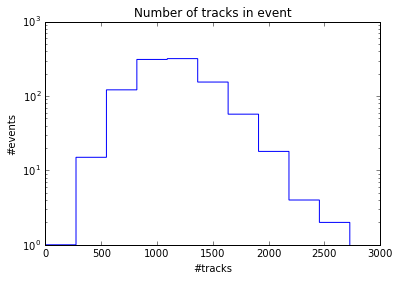

In [24]:
nt = nt(events2017B_HL)
fig, ax = plt.subplots()
ax.hist(nt,histtype='step', fill=False)
ax.set_title('Number of tracks in event')
ax.set_xlabel('#tracks')
ax.set_ylabel('#events')
plt.yscale('log', nonposy='clip')
plt.show()

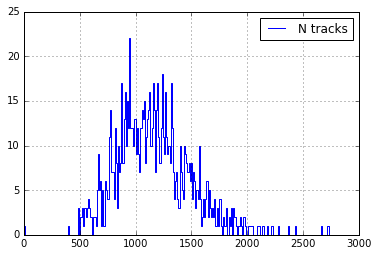

In [25]:
y,x = np.histogram(nt,np.linspace(0.,3000.,300))
x.resize(len(y))
plt.step(x,y,where='post',label='N tracks')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

In [26]:
def loadTk(events) :
    tkParsA = []
    tkHitsA = []
    for i in range(0,2000) : # events.size()):
      a= events.to(i)
      if (i%500==0) : 
        id = events.object().id()
        evid = '{:d}:{:d}:{:d}'.format(int(id.run()),int(id.luminosityBlock()), int(id.event()))
        print "Event", i , evid
      a=events.getByLabel(label, tracks)
      for tk in tracks.product() :
        if (not tk.quality(tk.qualityByName(quality))) : continue
        pattern = tk.hitPattern()
        tkParsA.append([tk.eta(),tk.phi(),tk.pt(),pattern.numberOfValidHits(),pattern.numberOfValidPixelHits(),tk.ndof(),tk.chi2(),tk.originalAlgo()-4])
        tkHitsA.append([pattern.getTrackerLayerCase(0,1,1), pattern.getTrackerLayerCase(1,1,1),\
                        pattern.getTrackerLayerCase(0,1,2), pattern.getTrackerLayerCase(1,1,2),\
                        pattern.getTrackerLayerCase(0,2,1), pattern.getTrackerLayerCase(1,2,1)])

    print len(tkParsA)
    tkPars = np.array(zip(*tkParsA))
    print len(tkPars)
    tkHits = np.array(zip(*tkHitsA))
    print len(tkHits)
    return (tkPars,tkHits)

In [27]:
tkPars, tkHits = loadTk(events2017B_LL)

Event 0 299067:23:26929302
Event 500 299067:23:27292434
Event 1000 299067:23:26656881
Event 1500 299067:23:26264722
1316998
8
6


4.0 0 999999

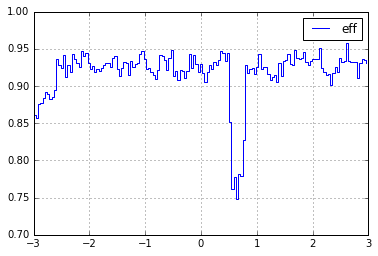

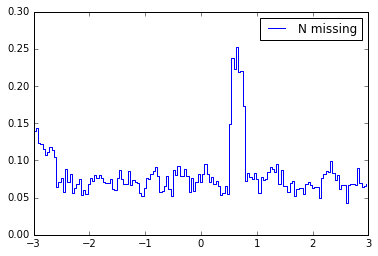

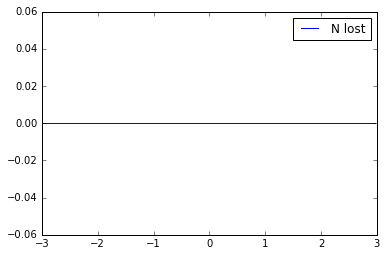

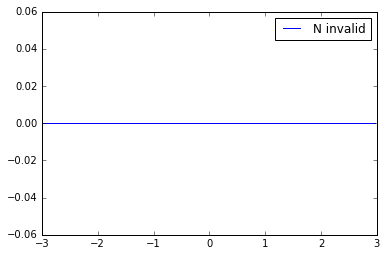

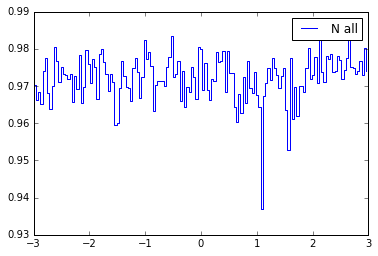

In [28]:
print tkPars[4][0],tkHits[0][0],tkHits[1][0],
eta=0
phi=1
pt=2

var = phi
hp = np.greater(tkPars[2],1.)
valL2 = np.equal(tkHits[2],0)
valF1 = np.equal(tkHits[4],0)
hp = hp&(valL2|valF1)

yv,x = np.histogram(tkPars[var],np.linspace(-3.,3.,150),weights=1.*hp*np.equal(tkHits[0],0)) 
yl,x = np.histogram(tkPars[var],np.linspace(-3.,3.,150),weights=1.*hp*np.equal(tkHits[0],1)) 
yi,x = np.histogram(tkPars[var],np.linspace(-3.,3.,150),weights=1.*hp*np.equal(tkHits[0],2)) 
ym,x = np.histogram(tkPars[var],np.linspace(-3.,3.,150),weights=1.*hp*np.less(tkHits[1],10)) 
ya=yv+ym+yl
y2,x = np.histogram(tkPars[var],np.linspace(-3.,3.,150),weights=1.*hp)
x.resize(len(yv))
plt.step(x,yv/ya,where='post',label='eff')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()
plt.step(x,ym/ya,where='post',label='N missing')
plt.legend(loc='upper right')
plt.show()
plt.step(x,yl/ya,where='post',label='N lost')
plt.legend(loc='upper right')
plt.show()
plt.step(x,yi/ya,where='post',label='N invalid')
plt.legend(loc='upper right')
plt.show()
plt.step(x,ya/y2,where='post',label='N all')
plt.legend(loc='upper right')
plt.show()